In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import models,transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device)

cuda


In [3]:
path = "../input/aptos2019-blindness-detection/"
train_df = pd.read_csv(f"{path}train.csv")
print(f'No.of.training_samples: {len(train_df)}')

No.of.training_samples: 3662


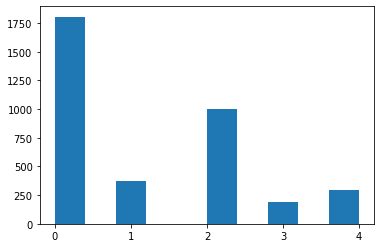

In [4]:
#Histogram of label counts.
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [5]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
print(class_weights) 

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


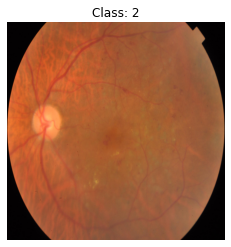

In [6]:
path = "../input/dr-aptos2019-preprocessed/"
num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
sample_image = (f'{path}train_images/{train_df["id_code"][num]}.png')#Image file.
sample_image = Image.open(sample_image) 
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: {train_df["diagnosis"][num]}') #Class of the random image.
plt.show()

In [7]:
def one_hot(x):
    return torch.eye(5)[x,:]

In [8]:
class dataset(Dataset):
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = one_hot(self.df['diagnosis'][index]) #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.
            

In [9]:
path="../input/dr-aptos2019-preprocessed/"
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                     # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.
data_set = dataset(train_df,f'{path}train_images',image_transform=image_transform)

train_set,valid_set = torch.utils.data.random_split(data_set,[3302,360],generator=torch.Generator().manual_seed(989))

In [10]:
print(torch.manual_seed(40))

In [11]:
train_dataloader = DataLoader(train_set,batch_size=4,shuffle=True) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=4,shuffle=False) #DataLoader for validation_set.

In [12]:
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score

def validate():
    model.eval()
    total = 0
    correct = 0
    running_loss = 0
    pred_lst = []
    gt_lst = []
    with torch.no_grad():
        for x,y in valid_dataloader:
            print(x.shape)
            x= x.to(device)
            output= model(x) #model's output.
            output=output.detach().cpu().numpy()
            #output=output.numpy()
            #print(output)
            pred_lst.append(output)
            gt_lst.append(y)
            del x, y, output
            
        
        pred_lst=np.concatenate(pred_lst, axis=0)
        gt_lst=np.concatenate(gt_lst, axis=0)
        #print(pred_lst)
        #for i in range(len(gt_lst)):                     
            #print(np.mean(pred_lst[i][0],axis=0))
            #print(np.sum(pred_lst,axis=0))
        pred_lst2 = np.argmax(pred_lst, axis=1)
        #print(pred_lst2)
        #print("\n")
        gt_lst2 = np.argmax(gt_lst, axis=1)
        auc_lst=[]
        acc_lst=[]
        for k in range(0,5):
            tmp_gt=gt_lst[:, k]
            tmp_pred=pred_lst[:,k]
            tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
            acc_lst.append(tmp_acc)
            try:
                tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
            except ValueError:
                tmp_auc=0
            auc_lst.append(tmp_auc)

        auc_lst=np.array(auc_lst)
        acc_lst=np.array(acc_lst)
        print('AUC Classwise Score on Validation set = ', auc_lst)
        print('ACC Classwise Score on Validation set = ', acc_lst)
        auc=np.mean(auc_lst)
        acc = np.mean(acc_lst)
        print('AUC Score on Validation set = ', auc)
        print('ACC Score on Validation set = ', acc)
        f1 = f1_score(gt_lst2, pred_lst2, average='weighted')
        print('F1 Score on Validation set = ', f1)
        cohen_kappa = cohen_kappa_score(gt_lst2, pred_lst2,weights="quadratic")
        print("Cohen's Kappa Score on Validation set = ", cohen_kappa)
        print(classification_report(gt_lst2, pred_lst2, labels=[0,1, 2, 3,4]))
        model.train()
        return auc,acc,f1,cohen_kappa

In [13]:
def train():
    total_batches=len(train_dataloader)
    cycle_length= len(train_dataloader)*2
    loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss
    optimizer = torch.optim.SGD(model.parameters(),lr=0.001) 
    model.train()
    total = 0
    correct = 0
    running_loss=0
    count=0
    max_epochs=50 #18
    
    
    for epoch in range(0, max_epochs):
        for batch,(x,y) in enumerate(train_dataloader):
            output = model(x.to(device)) #model's predictions.
            y=y.long()
            loss   = loss_fn(output,torch.max(y.to(device), 1)[1])
            running_loss=running_loss+loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (batch+1) % 25 == 0: # displays after every 20 batches
                    print ("Epoch [{}/{}], Batch [{}/{}] Classification Loss: {:.4f}".format(epoch+1, max_epochs, batch+1, total_batches, running_loss/(batch+1) ), end ="\r")
                    
            count=count+1
            if count>=cycle_length:
                count=0
                auc,acc,f1,cohen_kappa=validate()
                auc=np.round(auc,4)
                nm='DR_CNN_Model_Ens_'+str(auc)+'_mode.pt'
                torch.save({'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict()}, nm)
                del nm
                running_loss=0
                
    return model

In [14]:
from scipy.stats import bernoulli, uniform

In [15]:
bernoulli.rvs(0.5, size=1)

array([0])

In [16]:
import torch
import torch.nn as nn

class ENS_MOD(nn.Module):
    def __init__(self, model1,model2,model3,model4):
        super(ENS_MOD, self).__init__()
        self.features1 = model1
        self.features2 = model2
        self.features3 = model3
        self.features4 = model4
        self.transform1 = transforms.ColorJitter(brightness=0.15,contrast=(0.5, 1.5),saturation=(0.5, 2.5),hue=0.15)
        self.transform2 = transforms.RandomResizedCrop(512, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333))
        self.transform3 = transforms.RandomHorizontalFlip(p=bernoulli.rvs(0.5, size=1)[0])
        self.transform4 = transforms.RandomVerticalFlip(p=bernoulli.rvs(0.5, size=1)[0]) 
        #self.sftm=torch.nn.Softmax(dim=0)

                                               
    
    def forward_feature(self, x):
        """x1 = self.features1(x)
        x2 = self.features2(x)
        x3 = self.features3(x)
        x4 = self.features4(x)
        print(x1)"""
        x1 = torch.unsqueeze(self.features1(self.transform1(x)),-1)
        x2 = torch.unsqueeze(self.features2(self.transform2(x)),-1)
        x3 = torch.unsqueeze(self.features3(self.transform3(x)),-1)
        x4 = torch.unsqueeze(self.features4(self.transform4(x)),-1)
        
        x= torch.cat((x1,x2,x3,x4),2)
        """a = x.argmax(1)
        a = a.cpu()
        x = x.cpu()
        x = torch.zeros (x.shape).scatter (1, a.unsqueeze (1), 1.0)
        x = x.to(device)"""
        #print(x)
        x = torch.mode(x,dim=2)
        #print("mode - ",x)
        return x[0]
    
    def forward(self, x):
        out = self.forward_feature(x)
        return out

    def get_config_optim(self, lr):
        return [{'params': self.parameters(), 'lr': lr}]

In [17]:
def get_model():
    model_dict = {'ENS_MOD': ENS_MOD}
    backbone1=models.resnet50()
    backbone2=models.resnet50()
    backbone3=models.resnet50()
    backbone4=models.resnet50()
    backbone1.fc=nn.Sequential(nn.Linear(2048,5),nn.Sigmoid())
    backbone2.fc=nn.Sequential(nn.Linear(2048,5),nn.Sigmoid())
    backbone3.fc=nn.Sequential(nn.Linear(2048,5),nn.Sigmoid())
    backbone4.fc=nn.Sequential(nn.Linear(2048,5),nn.Sigmoid())
    checkpoint = torch.load('../input/dr-resnet-50-new/DR_CNN_Model_RESENET50.pt_0.6545996104937565')
    backbone1.load_state_dict(checkpoint['model_state_dict'],strict=False)
    del checkpoint
    checkpoint = torch.load('../input/dr-resnet-50-new/DR_CNN_Model_RESENET50.pt_0.6721656333038087')
    backbone2.load_state_dict(checkpoint['model_state_dict'],strict=False)
    del checkpoint
    checkpoint = torch.load('../input/dr-resnet-50-new/DR_CNN_Model_RESENET50.pt_0.6835457441966318')
    backbone3.load_state_dict(checkpoint['model_state_dict'],strict=False)
    del checkpoint
    checkpoint = torch.load('../input/dr-resnet-50-new/DR_CNN_Model_RESENET50.pt_0.6848372801174519')
    backbone4.load_state_dict(checkpoint['model_state_dict'],strict=False)
    del checkpoint
    model = model_dict['ENS_MOD'](backbone1,backbone2,backbone3,backbone4)
    return model

In [18]:
model = get_model()
model = model.to(device)

In [19]:
print(model)

ENS_MOD(
  (features1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [20]:
validate()

torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6146018604939252,
 0.8555555555555555,
 0.42560677696396615,
 0.44224250325945236)

In [21]:
train()

torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ENS_MOD(
  (features1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

checkpoint = torch.load('DR_CNN_Model_Ens0.8291.pt')

AUC Classwise Score on Validation set =  [0.92623561 0.79198393 0.78877673 0.81812552 0.78811648]
ACC Classwise Score on Validation set =  [0.925      0.81388889 0.74166667 0.88611111 0.65833333]
AUC Score on Validation set =  0.8226476545446385
ACC Score on Validation set =  0.805
F1 Score on Validation set =  0.6660594217635571
Cohen's Kappa Score on Validation set =  0.6944837340876946
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       167
           1       0.36      0.27      0.31        37
           2       0.57      0.77      0.65       111
           3       0.33      0.07      0.12        14
           4       0.00      0.00      0.00        31

    accuracy                           0.71       360
   macro avg       0.43      0.41      0.40       360
weighted avg       0.64      0.71      0.67       360